In [35]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import shap
import matplotlib.pyplot as plt


In [25]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [26]:
df_balanced = pd.read_csv("../dataset/embled_review_combined.csv", encoding='utf-8')

In [27]:
# Parameters
embedding_size = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 300  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

In [28]:
sentences = [row.split() for row in df_balanced['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=embedding_size, window=5, min_count=1, workers=4) 

In [29]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [30]:
print(f"X {X.shape}")
print(f"X {y.shape}")

X (14067, 300)
X (14067,)


In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [31]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [33]:
# Step 6: Build the GRU Model
gru_units = 128
dropout_rate = 0.5
input_shape = X_train_resampled.shape[1:] 

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_size,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(GRU(units=gru_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(GRU(units=gru_units))
model.add(Dropout(dropout_rate))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))   # 3 classes: negative, neutral, positive



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     4,472,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,472,700 (17.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,472,700 (17.06 MB)

In [36]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.3, random_state=42)

# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")

X_train shape: (9846, 300)
y_train shape: (9846,)
X_test shape: (4221, 300)
y_test shape: (4221,)


In [29]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

NameError: name 'y_train' is not defined

In [34]:
class_weights_dict = dict(enumerate(class_weights))

In [35]:
class_weights_dict

{0: 4.190602836879433, 1: 2.643736017897092, 2: 0.419618286728806}

In [ ]:
# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/GRU_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=None)


Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 827ms/step - accuracy: 0.9914 - loss: 0.0224 - val_accuracy: 0.9728 - val_loss: 0.1286
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 62s 811ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.9635 - val_loss: 0.1997
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9973 - loss: 0.0086

In [38]:
# 1. Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 2. Make Predictions
y_pred_prob = model.predict(X_val)

# If your output layer is using 'softmax', y_pred_prob will be probabilities for each class.
# To get the predicted class labels, you can use np.argmax:
y_pred_class = np.argmax(y_pred_prob, axis=1)

# 3. Compare the predicted labels with the true labels
# print(f'Predicted classes: {y_pred_class[:20]}')  # Display the first 10 predictions
# print(f'True classes: {y_val[:20]}')  

132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.9648 - loss: 0.1355
Test Loss: 0.1343
Test Accuracy: 0.9661
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step


In [39]:
conf_matrix = confusion_matrix(y_val, y_pred_class)

print("Accuracy:", accuracy_score(y_val, y_pred_class))
print(classification_report(y_val, y_pred_class))
print(conf_matrix)

Accuracy: 0.9661217720919213
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1453
           1       0.94      0.97      0.95      1374
           2       0.96      0.93      0.95      1394

    accuracy                           0.97      4221
   macro avg       0.97      0.97      0.97      4221
weighted avg       0.97      0.97      0.97      4221

[[1447    0    6]
 [   0 1330   44]
 [  11   82 1301]]


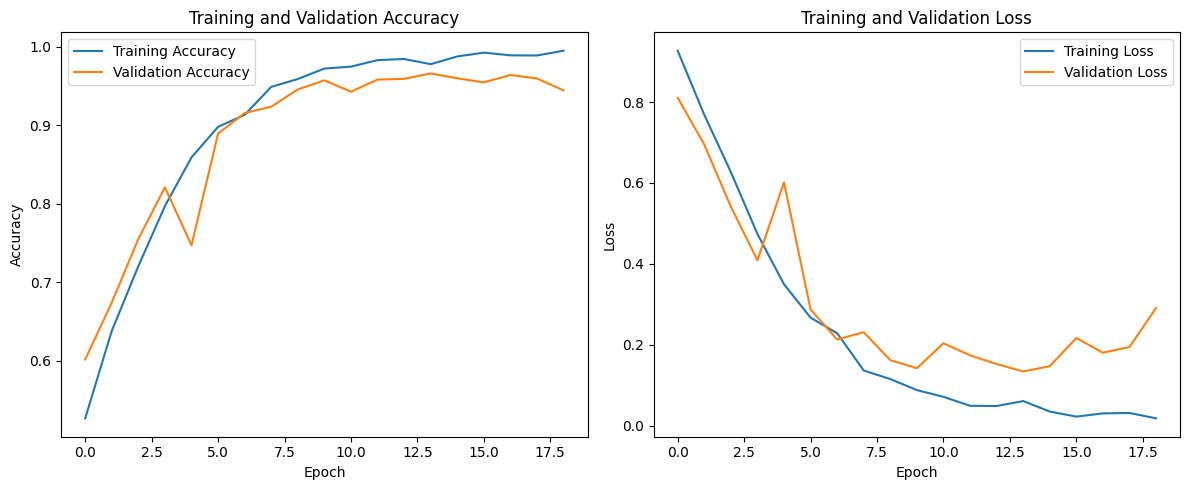

In [40]:
acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [153]:


# predictions_df = pd.DataFrame(data=y_pred_class, index=y_test.index, columns=['predicted_sentiment'])

# review_df.loc[y_test.index, 'predicted_sentiment'] = predictions_df['predicted_sentiment']


In [161]:

predictions_df = pd.DataFrame({
    'review_text': review_df.loc[y_test.index, 'review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': y_test,  # The actual sentiment labels
    'predicted_sentiment': y_pred_class  # The predicted sentiment labels
})

predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.head(5)


,review_text,actual_sentiment,predicted_sentiment
3489,While I should probably come back at a better ...,negative,positive
4909,Nice place Have Food Court KFC Lawson Bic C Se...,positive,positive
1425,Since I was born and grew up in Ceylon (Sri La...,positive,positive
4743,This shrine is located in front of Central\nWo...,neutral,positive
439,Wat Suan Dok is just east of the Old City on S...,positive,positive


In [41]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_class)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9661


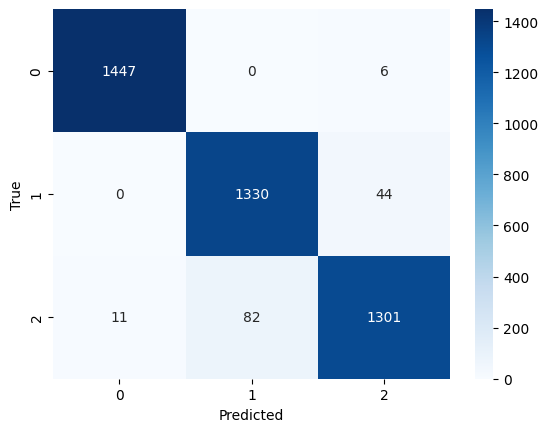

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [137]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        91
     neutral       0.00      0.00      0.00       157
    positive       0.79      1.00      0.88       934

    accuracy                           0.79      1182
   macro avg       0.26      0.33      0.29      1182
weighted avg       0.62      0.79      0.70      1182



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [163]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.6244
Recall: 0.7902
F1-Score: 0.6976


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

Macro-Averaged AUC: 0.5000
Micro-Averaged AUC: 0.8566


In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264


In [166]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_class)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.0000
